In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pickle

In [2]:
from PIL import Image

In [3]:
from skimage.color import rgb2hsv, rgb2lab, hsv2rgb, lab2rgb
from matplotlib.colors import hsv_to_rgb

In [4]:
from LogGabor import LogGabor

from PYramid2 import cropped_pyramid, local_filter, get_K, log_gabor_transform
from PYramid2 import inverse_pyramid, get_K_inv, inverse_gabor


Default lg shape= 32 32


In [5]:
width = 32
n_levels = 7 #int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
base_levels = 2
n_color = 3
r_min = width / 8 
r_max = width / 2 
n_sublevel = n_eccentricity = 4
n_azimuth = 16
n_theta = 8
n_phase = 1

In [6]:
phase_shift = False

In [7]:
pyramid_n_params = width*width*n_color*n_levels
print('pyramids #params :', pyramid_n_params)
logpolar_n_params = n_levels * n_color * n_eccentricity * n_azimuth * n_theta * n_phase
print('logpolar #params :', logpolar_n_params)

pyramids #params : 21504
logpolar #params : 10752


In [8]:
out_chan = 1024
gauss = False
do_mask = False
color = True
color_mode= 'lab' # 'hsv' 
print ('encoder #params :', out_chan)

encoder #params : 1024


In [9]:
if gauss:
    script_name = '2021-03-11-log-polar-deep-convolutional-no-max-pool-VAE-gauss-'+color_mode
else:
    script_name = '2021-03-11-log-polar-deep-convolutional-no-max-pool-VAE-laplace-'+color_mode

### Image utilities

In [10]:
def tensor_pyramid_display(img_pyr_tens, global_bias = 0):
    fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
    img_aff = img_pyr_tens.permute(0,1,3,4,2).detach().numpy()
    for i_level, ax in enumerate(axs):
        if i_level < n_levels-1 and not gauss:
            bias = 128
        else:
            bias = global_bias
        ax.imshow((img_aff[0, i_level, ...]+bias).clip(0,255).astype('uint8'))
        ax.plot([width/2], [width/2], 'r+', ms=32);
    #print('Tensor shape=', img_rec.shape) 
    return axs

In [11]:
def tensor_image_cmp(img_tens_ref, img_tens_rec):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    img_aff_ref = img_tens_ref.detach().permute(0,2,3,1).squeeze().detach().numpy().clip(0,255).astype('uint8')
    ax[0].imshow(img_aff_ref)
    N_X, N_Y, _ = img_aff_ref.shape
    ax[0].plot([N_Y//2], [N_X//2], 'r+', ms=16)
    ax[0].set_title('LOG GABOR RECONSTRUCTION')
    img_aff_rec = img_tens_rec.detach().permute(0,2,3,1).squeeze().detach().numpy().clip(0,255).astype('uint8')
    ax[1].imshow(img_aff_rec)
    ax[1].plot([N_Y//2], [N_X//2], 'r+', ms=16)
    ax[1].set_title('AUTO-ENCODER RECONSTRUCTION')
    return ax

In [12]:
def image_show(im, color_mode):
    if color_mode=='hsv':
        plt.imshow(hsv2rgb(im))
    elif color_mode=='lab':
        plt.imshow(lab2rgb(im))
    else:
        full_img_rec = im.clip(0,255).astype('uint8')
        plt.imshow(im)

### Log Gabor filters

In [13]:
pe = {'N_X': width, 'N_Y': width, 'do_mask': do_mask, 'base_levels':
          base_levels, 'n_theta': 0, 'B_sf': np.inf, 'B_theta': np.inf ,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}   

lg = LogGabor(pe)

print('lg shape=', lg.pe.N_X, lg.pe.N_Y)


lg shape= 32 32


In [14]:
lg.pe

{'N_X': 32,
 'N_Y': 32,
 'do_mask': False,
 'base_levels': 2,
 'n_theta': 0,
 'B_sf': inf,
 'B_theta': inf,
 'use_cache': True,
 'figpath': 'results',
 'edgefigpath': 'results/edges',
 'matpath': 'cache_dir',
 'edgematpath': 'cache_dir/edges',
 'datapath': 'database/',
 'ext': '.pdf',
 'figsize': 14.0,
 'formats': ['pdf', 'png', 'jpg'],
 'dpi': 450,
 'verbose': 0,
 'mask_exponent': 3.0}

In [15]:
K = get_K(width=width,
          n_sublevel = n_sublevel, 
          n_azimuth = n_azimuth, 
          n_theta = n_theta,
          n_phase = n_phase, 
          r_min = r_min, 
          r_max = r_max, 
          log_density_ratio = 2, 
          verbose=True,
          phase_shift=phase_shift,
          lg=lg)

i_sublevel, sf_0, radius 0 0.36067376022224085 4.0
i_sublevel, sf_0, radius 1 0.3032892720469601 6.270485380032653
i_sublevel, sf_0, radius 2 0.25503486164919736 8.970562748477139
i_sublevel, sf_0, radius 3 0.21445790092553713 12.181513966089149
K shape= torch.Size([32, 32, 4, 16, 8, 1])
K min max= tensor(-0.3240) tensor(1.)


### Gabor filters pseudo-inverse

Filter tensor shape= torch.Size([32, 32, 4, 16, 8, 1])
Reshaped filter tensor= torch.Size([1024, 512])
Tensor shape= torch.Size([512, 1024])


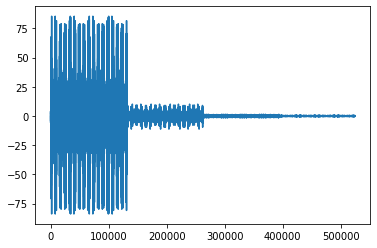

In [16]:
K_inv = get_K_inv(K, width=width, n_sublevel = n_sublevel, n_azimuth = n_azimuth, n_theta = n_theta, n_phase = n_phase)
plt.plot(K_inv.flatten())

### Honeycomb space coverage tests

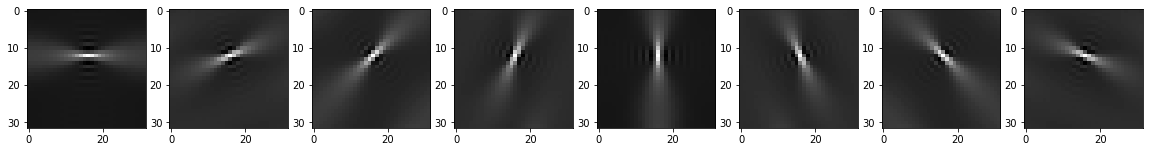

In [17]:
plt.figure(figsize=(20,3))
for i_theta in range(n_theta):
    coefs = torch.zeros((n_sublevel, n_azimuth, n_theta, n_phase))
    coefs[0, n_azimuth//2, i_theta, 0] = 1
    img_dis = torch.tensordot(K, coefs, dims=4)
    plt.subplot(1,n_theta,i_theta+1)
    plt.imshow(img_dis.numpy()[:, :, ...], cmap='gray')

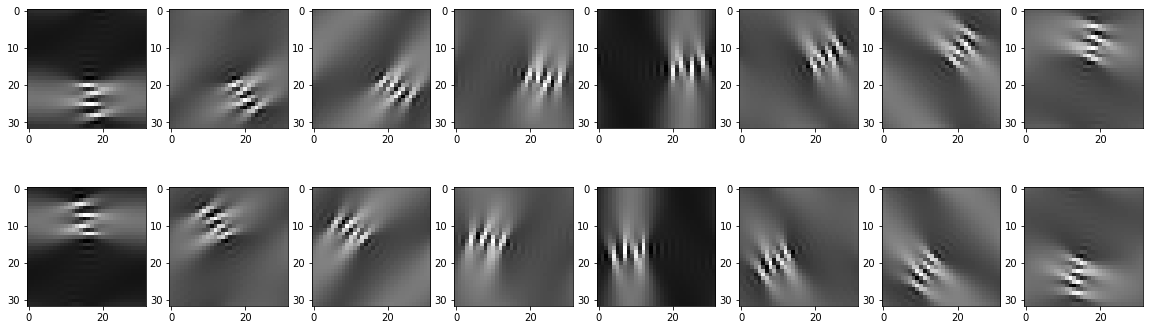

In [18]:
plt.figure(figsize=(20,6))
for i_az in range(n_azimuth):
    coefs = torch.zeros((n_sublevel, n_azimuth, n_theta, n_phase))
    coefs[:, i_az, 0, 0] = 1
    img_dis = torch.tensordot(K, coefs, dims=4)
    plt.subplot(2,n_azimuth//2,i_az+1)
    plt.imshow(img_dis.numpy()[:, :, ...], cmap='gray')

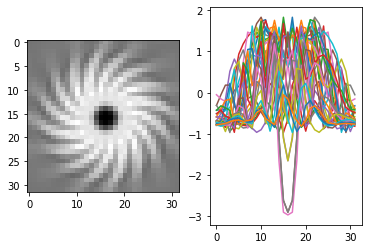

In [19]:
coefs = torch.zeros((n_sublevel, n_azimuth, n_theta, n_phase))
coefs[:, :, 2:3, 0] = torch.ones((n_sublevel, n_azimuth, 1))
img_dis = torch.tensordot(K, coefs, dims=4)
plt.subplot(1,2,1)
plt.imshow(img_dis.numpy(), cmap='gray')
plt.subplot(1,2,2)
_=plt.plot(img_dis.numpy())

## Images dataset + transforms

In [21]:
if True: #not os.path.exists("image_names.txt"):
    names = open("image_names.txt", "w")
    img_names = os.listdir('../ALLSTIMULI')
    print('EXCLUDED:')
    for i in range(len(img_names)):
        if 'Data1' in img_names[i] or 'Data2' in img_names[i] \
            or 'Data3' in img_names[i] or 'Data4' in img_names[i] \
            or 'DS_' in img_names[i] or len(img_names[i])<=10 :
            #or '2218506905' in img_names[i] or 'i24622350' in img_names[i]:
            print(img_names[i])
        else:
            names.write(img_names[i][:-5]+'\n')
    names.close()
    
names = open("image_names.txt", "r")
img_names = names.readlines()
for i in range(len(img_names)):
    img_names[i]=img_names[i][:-1]

EXCLUDED:
.DS_Store
.svn
syntheticData1.jpeg
syntheticData2.jpeg
syntheticData3.jpeg
syntheticData4.jpeg


In [22]:
dir_names = os.listdir('../saccades-data')
loc_data_xy={}
for dir_name in dir_names:
    loc_data_xy[dir_name]={}
    for name in img_names:
        locpath = '../saccades-data/' + dir_name + '/' + name
        f = open(locpath,'rb')
        loc_dict = pickle.load(f)
        loc_data_xy[dir_name][name] = np.array(loc_dict['barycenters'])

In [23]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    #plt.pause(0.001)  # pause a bit so that plots are updated

# Dataset class

In [24]:
class SaccadeLandmarksDataset(Dataset):
    """Saccade Landmarks dataset."""

    def __init__(self, loc_dict, img_dir, img_names, dir_names, transform=None, color_mode='rgb'):
        """
        Args:
            loc_dict (dict): Dictonary containing saccade coordinates
            img_dir (string): Directory with all the images.
            img_names (lost): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.loc_dict = loc_dict
        self.img_dir = img_dir
        self.img_names = img_names
        self.dir_names = dir_names
        self.transform = transform
        self.color_mode=color_mode

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx, color_mode='rgb'):

        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name + '.jpeg')
        image = io.imread(img_path)
        dir_name = np.random.choice(self.dir_names)
        landmarks = self.loc_dict[dir_name][name]
        landmarks = np.array([landmarks])
        landmarks = landmarks.reshape(-1, 2) #.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks, 'name':name}

        if self.transform:
            sample = self.transform(sample)

        return sample

# Transforms

In [25]:
class RandomSaccadeTo(object):
    # TODO : zero_fill option
    def __init__(self, zero_fill = False):
        self.zero_fill = zero_fill
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        N_X, N_Y = image.shape[:2]
        try:
            nb_sac = len(landmarks)
            sac_num =  np.random.randint(nb_sac)
            sac = landmarks[sac_num]
            #sac = np.random.choice(landmarks)
        except:
            print("landmarks", landmarks, "image", sample['name'])
            sac = (N_Y//2, N_X//2)
        
        image_roll = np.copy(image)
        image_roll=np.roll(image_roll, N_X//2 - sac[1], axis=0)
        if self.zero_fill:
            shift = N_X//2 - sac[1]
            if shift > 0:
                image_roll[:shift,:,:] = 0
            elif shift < 0:
                image_roll[shift:,:,:] = 0
        image_roll=np.roll(image_roll, N_Y//2 - sac[0], axis=1)
        if self.zero_fill:
            shift = N_Y//2 - sac[0]
            if shift > 0:
                image_roll[:,:shift,:] = 0
            elif shift < 0:
                image_roll[:,shift:,:] = 0
        return {'image':image_roll, 'pos':sac, 'name':sample['name']}

In [26]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image_tens = sample['image'].transpose((2, 0, 1))
        return {'image': torch.FloatTensor(image_tens), 'pos': sample['pos'],  'name':sample['name']}

### Adapted cropped pyramid (squeezed tensor)

In [27]:
class CroppedPyramid(object):
    def __init__(self, width, 
                 base_levels, 
                 color=color, 
                 do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb'):
        self.width = width
        self.base_levels = base_levels
        self.color = color
        self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode
    
    def __call__(self, sample):
        img_crop, level_size = cropped_pyramid(sample['image'].unsqueeze(0), 
                                               width=self.width, 
                                               base_levels=self.base_levels,
                                               color=self.color, 
                                               do_mask=self.do_mask, 
                                               verbose=self.verbose,
                                               squeeze=True,
                                               gauss=gauss,
                                               n_levels=self.n_levels,
                                               color_mode=self.color_mode)
        return{'img_crop':img_crop, 'level_size':level_size, 'pos':sample['pos'],  'name':sample['name']}
        
    

### LogGaborTransform

In [28]:
class LogGaborTransform(object):
    def __init__(self, K=K, color=color, verbose=False):
        self.K = K
        self.color = color
        self.verbose = verbose
    
    def __call__(self, sample):
        log_gabor_coeffs = log_gabor_transform(sample['img_crop'].unsqueeze(0), K)
        
        return{'img_gabor':log_gabor_coeffs, 'pos':sample['pos'],  'name':sample['name']}

# Compose transforms
### transforms.Compose

In [29]:
composed_transform = transforms.Compose([RandomSaccadeTo(zero_fill=True),
                               ToTensor(),
                               CroppedPyramid(width, 
                                              base_levels, 
                                              n_levels=n_levels,
                                              color_mode=color_mode)]) #, LogGaborTransform()])

In [30]:
saccade_dataset = SaccadeLandmarksDataset(loc_dict=loc_data_xy,
                                          img_dir='../ALLSTIMULI/',
                                          img_names=img_names,
                                          dir_names =  dir_names,
                                          transform=composed_transform,
                                          color_mode=color_mode)

# Iterating through the dataset

In [31]:
# Helper function to show a batch

def show_landmarks_batch(sample_batched, color_mode='rgb'):
    """Show image with landmarks for a batch of samples."""
    for level in range(n_levels-1,0,-1):
        plt.figure()
        images_batch = torch.clone(sample_batched['img_crop'][:,level,:,:,:])
        if level < n_levels-1 and not gauss:
            images_batch+=128  
        batch_size = len(images_batch)
        im_size = images_batch.size(2)
        grid_border_size = 2

        grid = utils.make_grid(images_batch)
        plt.imshow(grid.numpy().transpose((1, 2, 0)).clip(0,255).astype('uint8'))

        plt.title('Batch from dataloader, level=' + str(level))


0 torch.Size([4, 7, 3, 32, 32])
0 ['i1843924285', 'i117772445', 'i1390242687', 'i2264134553']
1 torch.Size([4, 7, 3, 32, 32])
1 ['i2281902585', 'i132306741', 'i30may05_static_street_cambridge_p1010735', 'i1065019259']
2 torch.Size([4, 7, 3, 32, 32])
2 ['i2078195666', 'i2265201355', 'i156568569', 'istatic_outdoor_road_mallorca_spain_IMG_0642']
3 torch.Size([4, 7, 3, 32, 32])
3 ['i2089736919', 'i1325243029', 'i2211739055', 'i1133557495']


<Figure size 432x288 with 0 Axes>

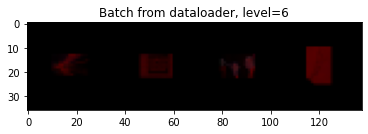

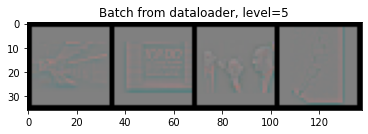

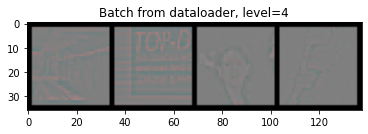

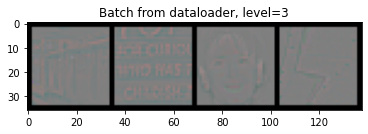

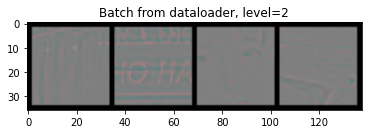

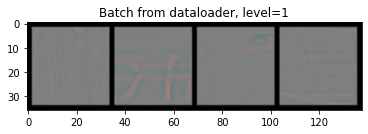

In [32]:
batch_size = 4
dataloader = DataLoader(saccade_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['img_crop'].size())
    print(i_batch, sample_batched['name'])
    if i_batch ==3 :
        plt.figure()
        show_landmarks_batch(sample_batched)  
        break
        

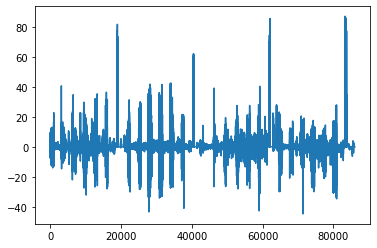

In [33]:
plt.plot(sample_batched['img_crop'].flatten())

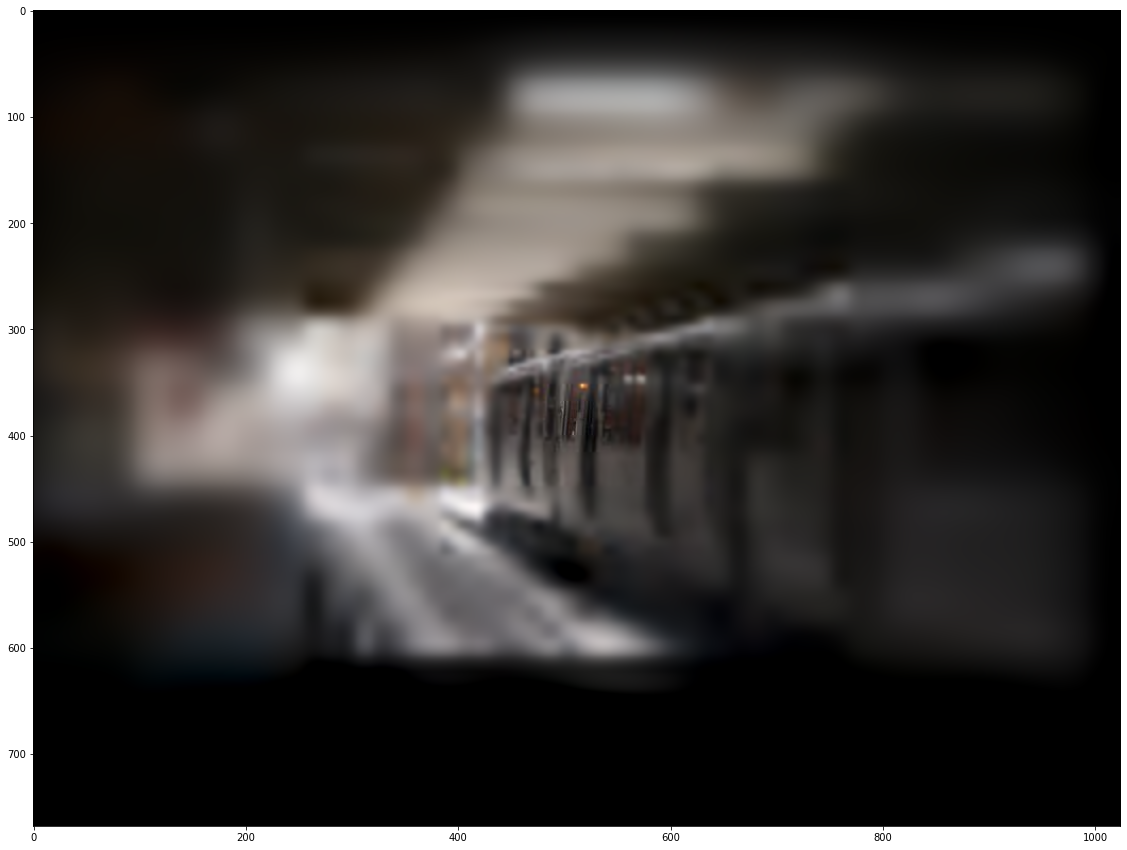

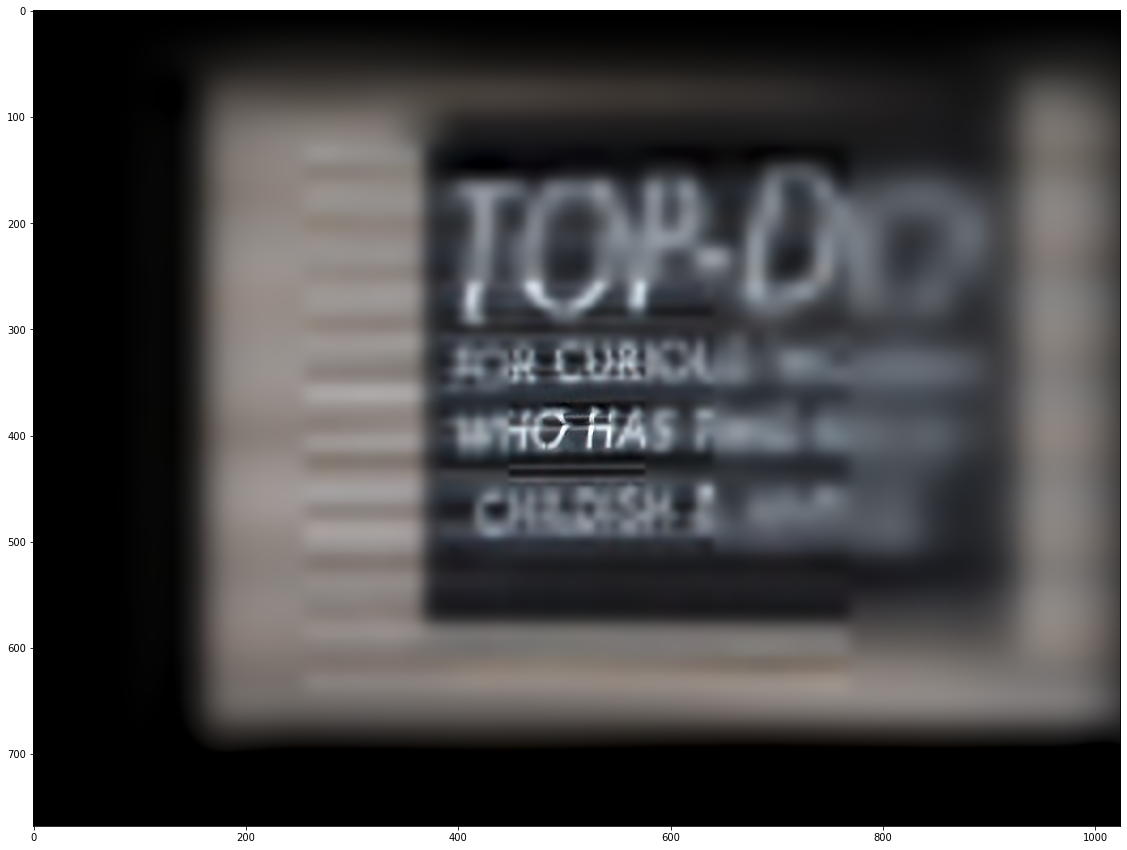

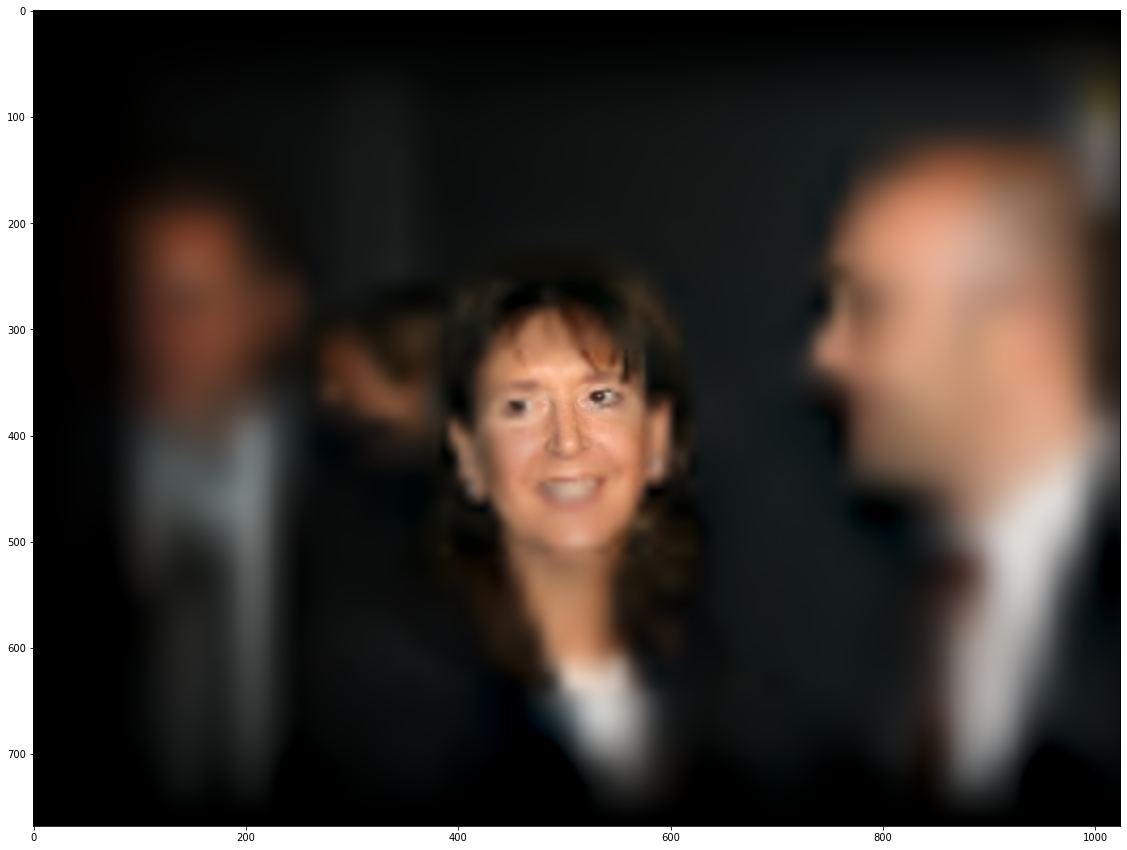

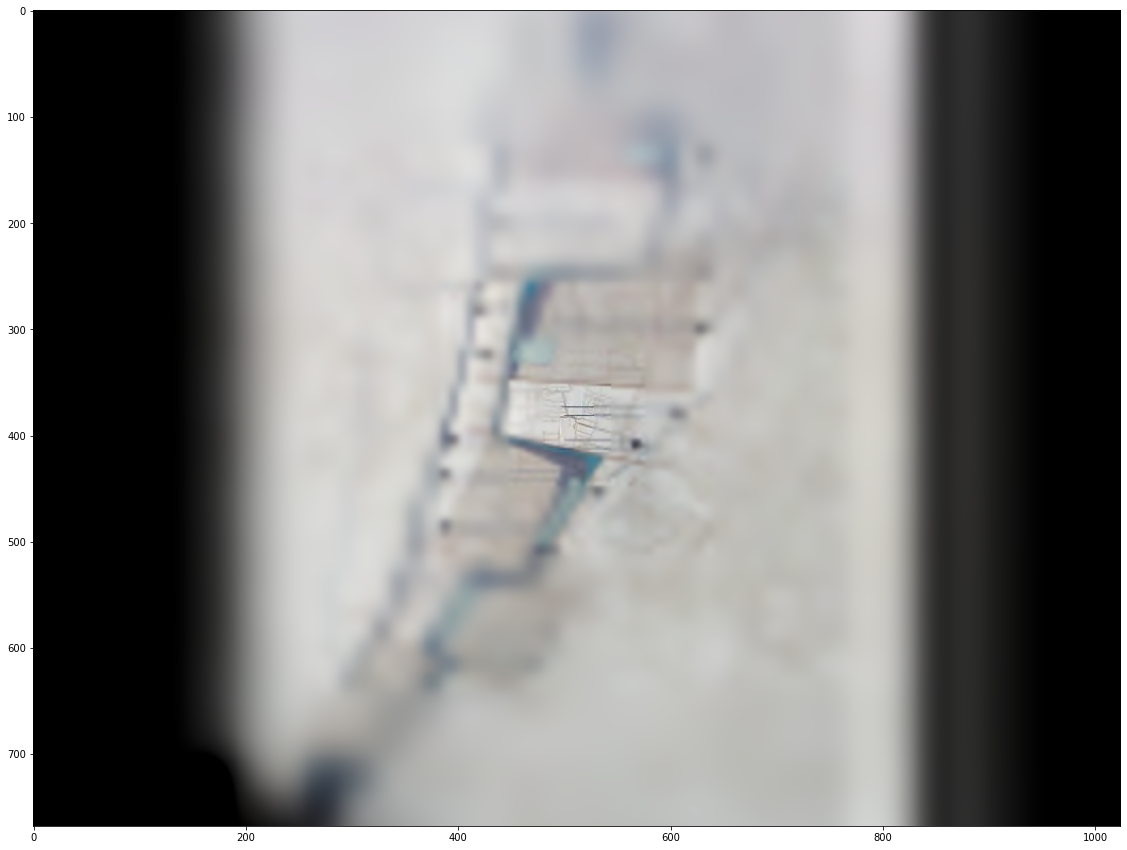

In [34]:
full_img_rec = inverse_pyramid(sample_batched['img_crop'], 
                               color=color, 
                               gauss=gauss, 
                               n_levels=n_levels)
if color_mode=='hsv' or color_mode=='lab':
    im = full_img_rec.detach().permute(0,2,3,1).numpy()
else:
    im = full_img_rec.detach().permute(0,2,3,1).numpy().clip(0,255).astype('uint8')
for num_batch in range(batch_size):
    plt.figure(figsize=(20,15))
    if color_mode == 'hsv':
        plt.imshow(hsv2rgb(im[num_batch,:]))
    elif color_mode == 'lab':
        plt.imshow(lab2rgb(im[num_batch,:]))
    else:
        plt.imshow(im[num_batch,:])

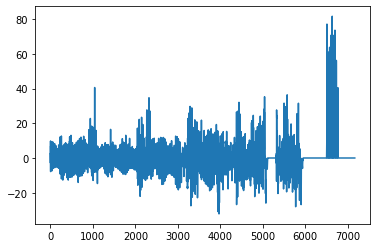

In [35]:
plt.plot(sample_batched['img_crop'][0,:,0,:,:].flatten())

### Autoencoder

In [47]:
class AutoEncoder(nn.Module):
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, 
                 out_chan = 32,
                 encoder=None,  decoder=None):
        super(AutoEncoder, self).__init__()
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase
        self.out_chan = out_chan
        
        if encoder is None:
            self.encoder = Encoder(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase)
        else:
            self.encoder = encoder
        
        self.h_size = n_levels * n_azimuth//4 * 128
         
        self.fc_mu = nn.Linear(self.h_size, out_chan)      
        self.fc_logvar = nn.Linear(self.h_size, out_chan)      
        
        self.fc_z_inv = nn.Linear(out_chan, self.h_size)            
        
        if decoder is None:
            self.decoder = Decoder(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase)    
        else:
            self.decoder = decoder
        
    def forward(self, x, z_in=None):   
        
        code = self.encoder(x)                  
        
        mu = self.fc_mu(code.view(-1, self.h_size))
        logvar = self.fc_logvar(code.view(-1, self.h_size))
        # sample z from q
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std) # `randn_like` as we need the same size

        if z_in is None:
            z = mu + (eps * std)
        else:
            z = z_in
        
        decode = self.fc_z_inv(z).view(-1, 128, self.n_levels, self.n_azimuth//4)        
        
        return self.decoder(decode), mu, logvar, z

In [48]:
class Encoder(nn.Module):
    """ Encoder
    """
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase):
        super(Encoder, self).__init__()
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase
        # Layers
        self.conv1 = nn.Conv2d(  n_color * n_phase * n_theta, 
                                 64, 
                                 kernel_size = (3,3), 
                                 stride = (2,2),
                                 padding = (1,1))        
        self.conv2 = nn.Conv2d(  64, 
                                 128, 
                                 kernel_size = (3,3), 
                                 stride = (2,2), 
                                 padding = (1,1)) #,
            
    def forward(self, x): 
        x = x.permute(0, 2, 5, 6, 1, 3, 4).contiguous()
        x = x.view(-1, self.n_color*self.n_theta*self.n_phase, self.n_levels * self.n_eccentricity, self.n_azimuth)
        x = self.conv1(x)
        x = nn.ReLU()(x) 
        #print(x.shape)
        
        x = self.conv2(x)
        x = nn.ReLU()(x) 
        #print(x.shape)
        
        return x 

In [49]:
class Decoder(nn.Module):
    """ Encoder
    """
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase):
        super(Decoder, self).__init__()
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase  
        
        self.unconv2 = nn.ConvTranspose2d(  128, 
                                 64, 
                                 kernel_size = (3,3), 
                                 stride = (2,2), 
                                 padding = (1,1),
                                 output_padding=(1,1))         
        self.unconv1 = nn.ConvTranspose2d(64, 
                                 n_color * n_theta * n_phase, 
                                 kernel_size = (3,3), 
                                 stride = (2,2), 
                                 padding = (1,1),
                                 output_padding=(1,1))
            
    def forward(self, x):          
        
        x = self.unconv2(x) 
        x = nn.ReLU()(x) 
        x = self.unconv1(x)
        x = x.view(-1, self.n_color, self.n_theta, self.n_phase, self.n_levels, self.n_eccentricity, self.n_azimuth)
        x = x.permute(0, 4, 1, 5, 6, 2, 3).contiguous()
        return x

In [50]:
class InverseLogGaborMapper(nn.Module):
    def __init__(self, in_chan = n_eccentricity * n_azimuth * n_theta * n_phase, 
                 out_chan = width * width):
        super(InverseLogGaborMapper, self).__init__()
        self.inverseMap = nn.Linear(in_chan, out_chan)
        
    def forward(self, x, **kargs):
        out = self.inverseMap(x) #!!
        return out #!!

### Model and learning params

In [51]:
batch_size = 50
autoenc_lr = 3e-5
invLG_lr = 3e-5

n_epoch = 1000
recording_steps = 10

In [52]:
autoenc_VAE = AutoEncoder(n_levels-1, n_color, n_eccentricity, n_azimuth, n_theta, 
                          n_phase, out_chan=out_chan)

invLGmap = InverseLogGaborMapper()

In [58]:
autoenc_VAE_optimizer = optim.Adam(autoenc_VAE.parameters(), lr = autoenc_lr)
        
invLG_optimizer = optim.Adam(invLGmap.parameters(), lr = invLG_lr)
criterion = nn.MSELoss(reduction='sum')

In [54]:
dataloader = DataLoader(saccade_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

In [55]:
KL_loss_list = []
MSE_loss_list = []
invLG_loss_list = []

In [56]:
script_name

'2021-03-11-log-polar-deep-convolutional-no-max-pool-VAE-laplace-lab'

In [ ]:
PATH = script_name + '_invLGmap.pt'

if not os.path.exists(PATH):    

    for epoch in range(n_epoch):  # loop over the dataset multiple times

        KL_running_loss = 0.0
        MSE_running_loss = 0.0
        invLG_running_loss = 0.0
        for step, data in enumerate(dataloader):

            batch_size_eff = data['img_crop'].shape[0]
            
            log_gabor_coefs = log_gabor_transform(data['img_crop'], K)

            # Normalizing
            autoenc_inputs = log_gabor_coefs[:,:n_levels-1,...].clone()
            if color_mode == 'rgb':
                autoenc_inputs /=  256 # !! Normalization
                
            autoenc_outputs, mu, logvar, z = autoenc_VAE(autoenc_inputs)
            autoenc_VAE_optimizer.zero_grad()
            MSE_loss = 0.5 * criterion(autoenc_outputs, autoenc_inputs)
            KL_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            autoenc_VAE_loss = MSE_loss + KL_loss
            autoenc_VAE_loss.backward()
            autoenc_VAE_optimizer.step()   

            invLG_optimizer.zero_grad()
            log_gabor_coefs_rec = autoenc_outputs.detach().view(batch_size_eff*(n_levels-1)*n_color,
                                                               n_eccentricity*n_azimuth*n_theta*n_phase)
            img_pyr_rec_rec = invLGmap(log_gabor_coefs_rec)

            img_pyr_targets = data['img_crop'][:,:n_levels-1,...].contiguous()
            img_pyr_targets = img_pyr_targets.view(batch_size_eff * (n_levels-1) * n_color, 
                                                   width * width)
            if color_mode == 'rgb':
                img_pyr_targets /=  256 # !! Normalization
            invLG_loss = criterion(img_pyr_rec_rec, img_pyr_targets)
            invLG_loss.backward()             
            invLG_optimizer.step()

            # print statistics
            KL_running_loss += KL_loss.item()
            MSE_running_loss += MSE_loss.item()
            invLG_running_loss += invLG_loss.item()
            if (step+1)%recording_steps == 0 :    # print every n_steps mini-batches
                print('[%d, %5d] losses: %.3f, %.3f, %.3f' %
                      (epoch + 1, 
                       step + 1, 
                       KL_running_loss/recording_steps, 
                       MSE_running_loss/recording_steps,
                       invLG_running_loss/recording_steps))
                #.append
                KL_loss_list.append(KL_running_loss/recording_steps)
                MSE_loss_list.append(MSE_running_loss/recording_steps)
                invLG_loss_list.append(invLG_running_loss/recording_steps)
                KL_running_loss = 0.0
                MSE_running_loss = 0.0
                invLG_running_loss = 0.0

    print('Finished Training ')
    
    if n_epoch !=0 :
        PATH = script_name + '_KL_loss_list.npy'
        np.save(PATH, np.array(KL_loss_list))    
        PATH = script_name + '_MSE_loss_list.npy'
        np.save(PATH, np.array(MSE_loss_list))    
        PATH = script_name + '_invLG_loss_list.npy'
        np.save(PATH, np.array(invLG_loss_list))   
        PATH = script_name + '_invLGmap.pt'
        torch.save(invLGmap, PATH)
        PATH = script_name + '_autoenc_VAE.pt'
        torch.save(autoenc_VAE, PATH)
        print('Model saved')

else:
    PATH = script_name + '_KL_loss_list.npy'
    KL_loss_list = np.load(PATH).tolist()    
    PATH = script_name + '_MSE_loss_list.npy'
    MSE_loss_list = np.load(PATH).tolist()    
    PATH = script_name + '_invLG_loss_list.npy'
    invLG_loss_list = np.load(PATH).tolist()
    PATH = script_name + '_invLGmap.pt'
    invLGmap = torch.load(PATH)
    PATH = script_name + '_autoenc_VAE.pt'
    autoenc_VAE = torch.load(PATH)
    print('Model loaded')

[1,    10] losses: 68800.143, 64154600.689, 16027460.866
[1,    20] losses: 38694.310, 64568219.631, 16257529.688
[2,    10] losses: 31791.343, 64116988.971, 16603092.196
[2,    20] losses: 28168.883, 63994038.056, 15638162.394
[3,    10] losses: 25615.924, 64724440.628, 15906284.812
landmarks [] image i176365896
[3,    20] losses: 22792.747, 63290785.156, 16059924.070
[4,    10] losses: 21560.107, 65487190.663, 16354292.088
[4,    20] losses: 19331.570, 64533388.748, 16452988.792
[5,    10] losses: 18106.708, 65941552.876, 16737322.788


In [ ]:
if False :
    PATH = script_name + '_KL_loss_list.npy'
    np.save(PATH, np.array(KL_loss_list))    
    PATH = script_name + '_MSE_loss_list.npy'
    np.save(PATH, np.array(MSE_loss_list))    
    PATH = script_name + '_invLG_loss_list.npy'
    np.save(PATH, np.array(invLG_loss_list))   
    PATH = script_name + '_invLGmap.pt'
    torch.save(invLGmap, PATH)
    PATH = script_name + '_autoenc_VAE.pt'
    torch.save(autoenc_VAE, PATH)
    print('Model saved')

In [ ]:
import seaborn
seaborn.set()
plt.figure(figsize=(5,12))
plt.plot(np.array(MSE_loss_list) , label = 'MSE')
plt.plot(np.array(KL_loss_list)*10 , label = 'KL')
plt.plot(np.array(invLG_loss_list) * 100, label = 'invLGMap')
#plt.ylim(0,500)
plt.title('LOSS')
plt.xlabel('# batch')
plt.legend()
plt.ylim(0,100000000)

In [ ]:
plt.hist(mu.detach().numpy().flatten(),20)
plt.figure()
plt.hist(logvar.detach().numpy().flatten(),20)


## Encoding and decoding

In [ ]:
seaborn.reset_orig()

In [ ]:
img_name = 'i1198772915'
if True:
    locpath = '../ALLSTIMULI/' + img_names[10] + '.jpeg'
    locpath = '../ALLSTIMULI/' + data['name'][4] + '.jpeg'
    locpath = '../ALLSTIMULI/' + img_name + '.jpeg'
    img_orig = Image.open(locpath) 
else:
    locpath= '../data/professional_test/test/namphuong-van-260.png'
    locpath= '../data/professional_test/test/shannon-kelley-108053.png'
    img_orig = Image.open(locpath)
    #img_orig = img_orig.resize((1024,768)) 

plt.figure(figsize=(20,15))
if color_mode=='hsv':
    img_orig = rgb2hsv(img_orig)
    plt.imshow(hsv2rgb(img_orig))
elif color_mode=='lab':
    img_orig = rgb2lab(img_orig)
    plt.imshow(lab2rgb(img_orig))
else:
    plt.imshow(img_orig)

In [ ]:
img_tens = torch.Tensor(np.array(img_orig)[None,...]).permute(0,3,1,2)


In [ ]:
img_crop = cropped_pyramid(img_tens, 
                           width=width,
                           color=color, 
                           do_mask=do_mask, 
                           verbose=True, 
                           n_levels=n_levels)[0]

In [ ]:
log_gabor_coeffs = log_gabor_transform(img_crop, K)
log_gabor_coeffs.shape

In [ ]:
full_img_rec.shape

In [ ]:
autoenc_inputs = log_gabor_coeffs[:,:n_levels-1,...].clone()

if color_mode == 'rgb':
    autoenc_inputs /= 256

log_gabor_coeffs_rec, mu, logvar, z = autoenc_VAE( autoenc_inputs )   
log_gabor_coeffs_rec = log_gabor_coeffs_rec.view(1, (n_levels-1), -1) 
if color_mode == 'rgb':
    log_gabor_coeffs_rec *= 256

In [ ]:
z

In [ ]:
log_gabor_coeffs_rec_cat = torch.cat((log_gabor_coeffs_rec.view(1, n_levels-1, n_color, n_eccentricity, n_azimuth, n_theta, n_phase), 
                                      log_gabor_coeffs[0:,-1:,...]), 1)

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(log_gabor_coeffs.numpy().flatten()[:], label = 'original')
plt.plot(log_gabor_coeffs_rec_cat.detach().numpy().flatten()[:], label = 'reconstructed')
plt.title('LOG GABOR COEFFS')
plt.legend()
for level in range(n_levels-1):
    plt.figure(figsize=(20,4))
    plt.plot(log_gabor_coeffs[0,level,...].numpy().flatten(), label = 'original')
    plt.plot(log_gabor_coeffs_rec[0,level,...].detach().numpy().flatten(), label = 'reconstructed')
    c = np.corrcoef([log_gabor_coeffs[0,level,...].numpy().flatten(), log_gabor_coeffs_rec[0,level,...].detach().numpy().flatten()])[0,1]
    plt.title('LOG GABOR COEFFS LEVEL '+str(level)+', corr='+str(c))
    plt.legend()


In [ ]:
_=plt.hist(log_gabor_coeffs.numpy().flatten(),100)

In [ ]:
_=plt.hist(img_crop.numpy().flatten(),100)

## Reconstruction tests

In [ ]:
K_inv = get_K_inv(K, width=width, n_sublevel = n_sublevel, n_azimuth = n_azimuth, n_theta = n_theta, n_phase = n_phase)
img_rec=inverse_gabor(log_gabor_coeffs.detach(), K_inv)
img_rec[:,-1,...] = img_crop[:,-1,...]
axs = tensor_pyramid_display(img_rec.clone()) 

In [ ]:
inv_LGmap_input = log_gabor_coeffs_rec.view((n_levels-1) * n_color, n_eccentricity * n_azimuth * n_theta * n_phase)
inv_LGmap_input.shape

In [ ]:
img_rec_rec = invLGmap(inv_LGmap_input) #inv_LGmap_input)
img_rec_rec = img_rec_rec.view(1, n_levels-1, n_color, width, width).detach()
img_rec_rec = torch.cat((img_rec_rec, img_crop[0:,-1:,...]), 1)
#img_rec_rec[0,-1,...] *=0 #+= 128
axs = tensor_pyramid_display(img_rec_rec)

### Test de invLGmap uniquement sur log gabor coeffs originaux

In [ ]:
img_rec_test = invLGmap(log_gabor_coeffs.view(n_levels * n_color, n_eccentricity * n_azimuth * n_theta * n_phase)) #inv_LGmap_input)
img_rec_test = img_rec_test.view(1, n_levels, n_color, width, width).detach()
img_rec_test[:,-1,...] = img_crop[:,-1,...]
axs = tensor_pyramid_display(img_rec_test)

### Test des coeffs reconstruits avec differentes valeurs de K_inv 

In [ ]:
img_rec_rec_test = []
for i, rcond in enumerate((0.1, 0.03, 0.01, 0.003, 0.001, 0)):
    K_ = K.reshape((width**2, n_sublevel*n_azimuth*n_theta*n_phase))
    print('Reshaped filter tensor=', K_.shape)
    if rcond>0:
        K_inv_test = torch.pinverse(K_, rcond=rcond) 
    else:
        K_inv_test = torch.pinverse(K_)
    print('Tensor shape=', K_inv.shape)
    K_inv_test =K_inv_test.reshape(n_sublevel, n_azimuth, n_theta, n_phase, width, width)
    img_rcond_test = inverse_gabor(log_gabor_coeffs.detach(), K_inv_test)
    img_rcond_test[:,-1,...] = img_crop[:,-1,...]
    axs = tensor_pyramid_display(img_rcond_test)
    axs[0].set_title('REGULARIZATION = '+str(rcond)+', ORIGINAL LOG-GABOR COEFS')
    img_rec_rcond_test = inverse_gabor(log_gabor_coeffs_rec_cat.detach(), K_inv_test)
    img_rec_rcond_test[:,-1,...] = img_crop[:,-1,...]
    img_rec_rec_test.append(img_rec_rcond_test)
    axs = tensor_pyramid_display(img_rec_rcond_test)
    axs[0].set_title('AUTO-ENCODER LOG-GABOR RECONSTRUCTION')    

### Full image reconstruction

In [ ]:
#img_crop = cropped_pyramid(img_tens, color=color, do_mask=do_mask, verbose=True, n_levels=n_levels)[0]
N_X, N_Y = full_img_rec.shape[1:3]


full_img_crop = inverse_pyramid(img_crop, color=color, gauss=gauss, n_levels=n_levels)
full_img_crop = full_img_crop.detach().permute(0,2,3,1).numpy()
    
plt.figure(figsize=(20,15))
image_show(full_img_crop[0,:], color_mode)
plt.title('RECONSTRUCTED FROM CROPPED PYRAMID, #params = ' + str(np.prod(img_crop[0,...].size())), fontsize=20)


img_rec=inverse_gabor(log_gabor_coeffs.detach(), K_inv)
img_rec[:,-1,...]= img_crop[:,-1,...]
full_img_rec = inverse_pyramid(img_rec, color=color, gauss=gauss, n_levels=n_levels)
full_img_rec = full_img_rec.detach().permute(0,2,3,1).numpy()
plt.figure(figsize=(20,15))
image_show(full_img_rec[0,:], color_mode)
plt.title('RECONSTRUCTED FROM LOG GABOR COEFFS, #params = ' + str(np.prod(log_gabor_coeffs[0,...].size())), fontsize=20)

full_img_rec_rec = inverse_pyramid(img_rec_rec, color=color, gauss=gauss, n_levels=n_levels)
full_img_rec_rec = full_img_rec_rec.detach().permute(0,2,3,1).numpy()
#ax = tensor_image_cmp(full_img_rec, full_img_rec_rec)
plt.figure(figsize=(20,15))
image_show(full_img_rec_rec[0,:], color_mode)
plt.title('RECONSTRUCTED FROM AUTO-ENCODER, #params = ' + str(out_chan), fontsize=20)


In [ ]:
#img_crop = cropped_pyramid(img_tens, color=color, do_mask=do_mask, verbose=True, n_levels=n_levels)[0]
plt.figure(figsize=(20,60))

plt.subplot(4,1,1)
img = img_tens.detach().permute(0,2,3,1).numpy()
N_X, N_Y = img.shape[1:3]
image_show(img[0,N_X//2-128:N_X//2+128,
               N_Y//2-128:N_Y//2+128,:], color_mode)
plt.title('ORIGINAL IMAGE, #params = ' + str(np.prod(img_tens[0,...].size())), fontsize=20)

plt.subplot(4,1,2)
full_img_crop = inverse_pyramid(img_crop, color=color, gauss=gauss, n_levels=n_levels)
full_img_crop = full_img_crop.detach().permute(0,2,3,1).numpy()
N_X, N_Y = full_img_crop.shape[1:3]
image_show(full_img_crop[0,N_X//2-128:N_X//2+128,
                         N_Y//2-128:N_Y//2+128,:], color_mode)
plt.title('RECONSTRUCTED FROM CROPPED PYRAMID, #params = ' + str(np.prod(img_crop[0,...].size())), fontsize=20)

plt.subplot(4,1,3)
img_rec=inverse_gabor(log_gabor_coeffs.detach(), K_inv)
img_rec[:,-1,...]= img_crop[:,-1,...]
full_img_rec = inverse_pyramid(img_rec, color=color, gauss=gauss, n_levels=n_levels)
full_img_rec = full_img_rec.detach().permute(0,2,3,1).numpy()
image_show(full_img_rec[0,N_X//2-128:N_X//2+128,
                        N_Y//2-128:N_Y//2+128,:], color_mode)
plt.title('RECONSTRUCTED FROM LOG GABOR COEFFS, #params = ' + str(np.prod(log_gabor_coeffs[0,...].size())), fontsize=20)

plt.subplot(4,1,4)
full_img_rec_rec = inverse_pyramid(img_rec_rec, color=color, gauss=gauss, n_levels=n_levels)
full_img_rec_rec = full_img_rec_rec.detach().permute(0,2,3,1).numpy()
#ax = tensor_image_cmp(full_img_rec, full_img_rec_rec)
image_show(full_img_rec_rec[0,N_X//2-128:N_X//2+128,
                            N_Y//2-128:N_Y//2+128,:], color_mode)
plt.title('RECONSTRUCTED FROM AUTO-ENCODER, #params = ' + str(np.prod(code[0,...].shape)), fontsize=20)

if False:
    plt.savefig(script_name+'.png', bbox_inches='tight')


In [ ]:
img.shape

In [ ]:
log_gabor_coeffs_roll = log_gabor_coeffs_rec.clone()
log_gabor_coeffs_roll = log_gabor_coeffs_roll.view(1,n_levels-1, n_color, n_eccentricity, n_azimuth, n_theta, n_phase)
#log_gabor_coeffs_roll[:,:n_levels-1,...]= log_gabor_coeffs_roll[:,:n_levels-1,...].roll(-4,4) #.roll(4, 4)
log_gabor_coeffs_roll= log_gabor_coeffs_roll.roll(1,4) #.roll(4, 4)
log_gabor_coeffs_roll= log_gabor_coeffs_roll.roll(1,1) #.roll(4, 4)

#log_gabor_coeffs_roll= log_gabor_coeffs_roll.roll(-1,5) #.roll(4, 4)
inv_LGmap_input = log_gabor_coeffs_roll.view((n_levels-1) * n_color, n_eccentricity * n_azimuth * n_theta * n_phase)
img_rec_rec_roll = invLGmap(inv_LGmap_input) #inv_LGmap_input)
img_rec_rec_roll = img_rec_rec_roll.view(1, n_levels-1, n_color, width, width).detach()
img_rec_rec_roll = torch.cat((img_rec_rec_roll, img_crop[0:,-1:,...]), 1)

full_img_rec_rec_roll = inverse_pyramid(img_rec_rec_roll, color=color, gauss=gauss, n_levels=n_levels)
full_img_rec_rec_roll = full_img_rec_rec_roll.detach().permute(0,2,3,1).numpy()
if color_mode == 'rgb':
    full_img_rec_rec_roll = full_img_rec_rec_roll.clip(0,255).astype('uint8')
#ax = tensor_image_cmp(full_img_rec, full_img_rec_rec)
plt.figure(figsize=(20,15))
image_show(full_img_rec_rec_roll[0,:], color_mode)
plt.title('ROTATION/ZOOM FROM COMPRESSED SENSING LAYER')
#log_gabor_coeffs_roll[:,:n_levels-1,...] = log_gabor_coeffs_roll[:,:n_levels-1,...].roll(1,1) #.roll(4, 4)

In [ ]:
z_test = torch.randn_like(mu)
logvar.shape

autoenc.out_chan
autoenc_inputs.shape

In [ ]:
log_gabor_coeffs_rec, mu, logvar, z = autoenc_VAE( autoenc_inputs)   
z_in = torch.randn_like(mu) * 10
log_gabor_coeffs_rec_test, mu, logvar, z = autoenc_VAE( autoenc_inputs, z_in=z_in )   
inv_LGmap_input = log_gabor_coeffs_rec_test.view((n_levels-1) * n_color, n_eccentricity * n_azimuth * n_theta * n_phase)
img_rec_rec_test = invLGmap(inv_LGmap_input) #inv_LGmap_input)
img_rec_rec_test = img_rec_rec_test.view(1, n_levels-1, n_color, width, width).detach()
img_rec_rec_test = torch.cat((img_rec_rec_test, torch.zeros_like(img_crop[0:,-1:,...])), 1)
full_img_rec_rec_test = inverse_pyramid(img_rec_rec_test, color=color, gauss=gauss, n_levels=n_levels)
full_img_rec_rec_test = full_img_rec_rec_test.detach().permute(0,2,3,1).numpy()
plt.figure(figsize=(20,15))
image_show(full_img_rec_rec_test[0,:], color_mode)
